In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist

# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Model parameters
L1, L2, L3, L4, L5 = 1024, 20, 20, 20, 10
NUM_ITERS = 1000
BATCH = 128
DISPLAY_STEP = 100


In [2]:
import tensorflow as tf
# Assuming (train_images, train_labels) and (test_images, test_labels) are already loaded and preprocessed as shown above

def prepare_datasets(batch_size=128):
    # Convert the numpy arrays into TensorFlow Dataset objects
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # Shuffle the training data (using a buffer larger than the number of examples to ensure good randomness)
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images))

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    # Prefetch the data (1 batch) to speed up training
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

# Example usage
batch_size = 10000
train_dataset, test_dataset = prepare_datasets(batch_size)


In [3]:
T= 10000
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

# Convert images to the right shape and type
X_MI = tf.convert_to_tensor(mnist_images[:T], dtype=tf.float32) / 255.0  # Normalize the data
X_MI = tf.expand_dims(X_MI, axis=-1)  # Add an extra dimension for channel

# Convert labels to one-hot encoded format if necessary
Y_MI = tf.convert_to_tensor(mnist_labels[:T])
Y_MI = tf.keras.utils.to_categorical(Y_MI, num_classes=10)

In [4]:
# Custom Model with MI Calculation
L1, L2, L3, L4, L5 = 1024, 20, 20, 20, 10
class CustomModel(models.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.dense1 = layers.Dense(L1, activation='relu')
        self.dense2 = layers.Dense(L2, activation='relu')
        self.dense3 = layers.Dense(L3, activation='relu')
        self.dense4 = layers.Dense(L4, activation='relu')
        self.dense5 = layers.Dense(L5, activation='softmax')

    def call(self, inputs):
        x = self.flatten(inputs)
        y1 = self.dense1(x)
        y2 = self.dense2(y1)
        y3 = self.dense3(y2)
        y4 = self.dense4(y3)
        y5 = self.dense5(y4)
        return y5, y1, y2, y3, y4

In [5]:

# Instantiate and compile model
model = CustomModel()
model.compile(optimizer=optimizers.Adam(0.003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
def get_MI_EDGE(model_outputs, ep_idx):
    """
    Calculates mutual information for all given model outputs.

    Args:
    model_outputs (list of np.array): Outputs from the model layers during inference.
    ep_idx (int): Current epoch index, used for calculations.

    Returns:
    list of tuples: Each tuple contains mutual information values (MI_XT, MI_TY).
    """
    mi_xt_list = []; mi_ty_list = []
    hidden_idx = 0
    for hidden_output in model_outputs:
        mi_xt, mi_ty = calc_MI_EDGE(hidden_output, hidden_idx, ep_idx)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
        hidden_idx += 1

    return mi_xt_list, mi_ty_list

In [7]:
def get_hidden_layers(model, names):
    """
    Retrieves hidden layers from a Keras model based on layer names.

    Args:
    model (tf.keras.Model): The model from which to retrieve layers.
    names (list of str): Names of the layers to retrieve.

    Returns:
    list of tf.Tensor: List of tensors corresponding to the outputs of the layers.
    """
    hidden_layers = []
    for name in names:
        # Access the layer directly from the model by name
        layer = model.get_layer(name)
        hidden_layers.append(layer.output)
    return hidden_layers

In [8]:
import numpy as np
from numpy.linalg import norm
global dist0
dist0 = np.zeros(4)


def calc_MI_EDGE(hidden, layer_idx, ep_idx):
    """
    Calculate mutual information metrics between hidden layer activations and both inputs and outputs.

    Args:
    hidden (np.array): Hidden layer activations.
    layer_idx (int): Index of the current layer.
    ep_idx (int): Current epoch index, for adjusting calculations.

    Returns:
    tuple: Contains mutual information values between inputs and hidden activations (MI_XT)
           and outputs and hidden activations (MI_TY).
    """
    # Assure hidden is a numpy array, and truncate samples for calculation
    hidden = np.array(hidden)[:T, :]
    X_reshaped = np.reshape(X_MI, [-1, 784])  # Vectorize X
    Y_reshaped = np.argmax(Y_MI, axis=1)  # Convert 10-dim data to class integer in [0,9]

    # Calculate or update distance measures
    if ep_idx <= 20:
        dist0[layer_idx] = av_distance(hidden)
        r = 1
    else:
        dist = av_distance(hidden)
        r = dist / dist0[layer_idx]

    print('Epoch index and hidden dimension and ratio:', ep_idx, hidden.shape[1], r)

    # Define smoothing vectors for mutual information calculations
    smoothness_vector_xt = np.array([0.8, 1.0, 1.2, 1.8])
    smoothness_vector_ty = np.array([0.4, 0.5, 0.6, 0.8])

    # Call the EDGE function to calculate mutual information
    mi_xt_py = EDGE(X_reshaped, hidden, U=20, L_ensemble=10, gamma=[0.2, smoothness_vector_xt[layer_idx]], epsilon_vector='range')
    mi_ty_py = EDGE(Y_reshaped, hidden, U=10, L_ensemble=10, gamma=[0.0001, smoothness_vector_ty[layer_idx]], epsilon=[0.2, 0.2], epsilon_vector='range')

    return mi_xt_py, mi_ty_py

# def av_distance(X):
#     """
#     Compute the average distance between random pairs of points in a given array.

#     Args:
#     X (np.array): Array of points.

#     Returns:
#     float: The average distance.
#     """
#     r = 1000
#     N = X.shape[0]
#     indices = np.random.choice(N, size=2*r, replace=False)
#     D = norm(X[indices[:r]] - X[indices[r:]], axis=1)
#     return np.mean(D)

# Find average distances between points
from numpy import linalg as LA
def av_distance(X):

  r = 1000

  N = X.shape[0]

  np.random.seed(1234)
  T1= np.random.choice(range(N), size=2*r)[:r]
  T2= np.random.choice(range(N), size=2*r)[r:]
  np.random.seed()
  D = LA.norm(X[T2,:] - X[T1,:], ord=2, axis=1)
  d = np.mean(D)

  return d

In [9]:
import numpy as np
import tensorflow as tf

def train_with_mi(model, train_dataset, test_dataset, epochs, batch_size):
    print('train_with_mi')

    # Compilation of the model should already be done outside this function, including optimizer and loss configuration
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    mi_xt_all = []
    mi_ty_all = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Iterate over batches of the dataset
        for step, (batch_X, batch_Y) in enumerate(train_dataset):
            # Run a training batch
            with tf.GradientTape() as tape:
                outputs = model(batch_X, training=True)
                predictions = outputs[0]
                loss = tf.keras.losses.categorical_crossentropy(batch_Y, predictions)

            # Calculate gradients and update model weights
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Calculate accuracy
            correct = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(batch_Y, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

            # Append loss and accuracy for visualization
            if step % DISPLAY_STEP == 0:
                train_losses.append(loss.numpy().mean())
                train_acc.append(accuracy.numpy())

                # Evaluate on test set
                # test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
                # test_losses.append(test_loss)
                # test_acc.append(test_accuracy)
                print(f"Step {step}: Train Loss: {loss.numpy().mean()}, Train Acc: {accuracy.numpy()}")

            # Compute Mutual Information at specified intervals
            # q=1
            # if (epoch <= 10 and step % 1 == 0) or \
            #   (epoch > 10 and epoch <= 100 and step % (3*q) == 0) or \
            #   (epoch > 100 and epoch <= 1000 and step % (25*q) == 0) or \
            #   (epoch > 1000 and epoch <= 2000 and step % (50*q) == 0) or \
            #   (epoch > 2000 and epoch <= 4000 and step % (200*q) == 0) or \
            #   (epoch > 4000 and step % (400*q) == 0):
            if epoch == 0 or epoch == 10 or epoch ==30 or epoch == 60 or (epoch >= 500 and epoch % 500 == 0):
                final_output, hidden1, hidden2, hidden3, hidden4 = model(X_MI, training=True)  # Forward pass to get hidden layer outputs
                hidden_outputs = [hidden1, hidden2, hidden3, hidden4]
                mi_xt, mi_ty = get_MI_EDGE(hidden_outputs, epoch)
                mi_xt_all.append(mi_xt)
                mi_ty_all.append(mi_ty)
                print(f'MI(X;T): {mi_xt}, MI(Y;T): {mi_ty}')

    return np.array(mi_xt_all), np.array(mi_ty_all)

In [10]:

# EDGE Estimator for Shannon Mutual Information
#
# Created by Morteza Noshad (noshad@umich.edu)
#
# Based on the paper: Scalable Mutual Information Estimation using Dependence Graphs
#
################
# The estimator is in the following form:
#
# I = EDGE(X,Y,U=u,gamma=[gamma_X,gamma_Y], epsilon=[eps_X, eps_Y], hashing)
#
# Arguments:
#
# X is N * d_x and Y is N * d_Y data sets
# U (optional) is an upper bound on the MI. It doesn't need to be accurate, but more accurate upper bound we set, faster convergence rates we get
# gamma=[gamma_X,gamma_Y] (optional) is the vector of soothness for X and Y.
#		For example, if the data is discrete we set gamma close to 0,
#		and if the data is continuous we set gamma close to 1 (or maybe higher if it is very smooth)
# epsilon=[eps_X, eps_Y] (optional) is the vector of bandwidths for X and Y. If no epsilon is set,
#		automatic bandwidths will be set.
# hashing (optional): possible arguments are 'p-stable' (default) which is a common type of LSH
#		or 'floor' which uses the simple floor function as hashing
#
# Output: I is the estimation of mutual information between X snd Y
###########################

import numpy as np
import math
#import cvxpy as cvx # Need to install CVXPY package,
					#  it is also possible to run this code without cvxpy, by setting uniform weights
import time
from scipy.special import *
from sklearn.neighbors import NearestNeighbors
def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)
#from random import randint, seed
#np.random.seed(seed=0)

#####################
#####################

# Generate W and V matrices (used in LSH)
def gen_W(X,Y):
	np.random.seed(3334)
	# Num of Samples and dimensions
	N = X.shape[0]
	dim_X , dim_Y  = X.shape[1], Y.shape[1]

	# parameters to control the dimension of W and V
	kx,ky = 2, 2
	rx,ry = 10,10

	# Find standard deviation vectors
	std_X = np.array([np.std(X[:,[i]]) for i in range(dim_X)])
	std_Y = np.array([np.std(Y[:,[i]]) for i in range(dim_Y)])

	std_X = np.reshape(std_X,(dim_X,1))
	std_Y = np.reshape(std_Y,(dim_Y,1))

	# Compute dimensions of W and V
	d_X_shrink=min(dim_X,math.floor(math.log(1.0*N/rx,kx)))
	d_Y_shrink=min(dim_Y,math.floor(math.log(1.0*N/ry,ky)))

	# Repeat columns of std_X and Y to be in the same size as W and V
	std_X_mat= np.tile(std_X,(1,d_X_shrink))
	std_Y_mat= np.tile(std_Y,(1,d_Y_shrink))

	# avoid devision by zero
	std_X_mat[std_X_mat<0.0001]=1
	std_Y_mat[std_Y_mat<0.0001]=1

	# Mean and standard deviation of Normal pdf for elements of W and V
	mu_X = np.zeros((dim_X, d_X_shrink))
	mu_Y = np.zeros((dim_Y, d_Y_shrink))

	sigma_X = 1.0/(std_X_mat *np.sqrt(dim_X))
	sigma_Y = 1.0/(std_Y_mat *np.sqrt(dim_Y))

	# Generate normal matrices W and V
	#np.random.seed(seed=0)
	W = np.random.normal(mu_X, sigma_X, (dim_X, d_X_shrink))
	V = np.random.normal(mu_Y, sigma_Y, (dim_Y, d_Y_shrink))

	return (W,V)

# Find KNN distances for a number of samples for normalizing bandwidth
def find_knn(A,d):
	np.random.seed(3334)
	#np.random.seed()
	#np.random.seed(seed=int(time.time()))
	r = 500
	# random samples from A
	A = A.reshape((-1,1))
	N = A.shape[0]

	k=math.floor(0.43*N**(2/3 + 0.17*(d/(d+1)) )*math.exp(-1.0/np.max([10000, d**4])))

	T= np.random.choice(A.reshape(-1,), size=r).reshape(-1,1)
	nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(A)
	distances, indices = nbrs.kneighbors(T)
	d = np.mean(distances[:,-1])
	return d

# Returns epsilon and random shifts b
def gen_eps(XW,YV):
	d_X , d_Y  = XW.shape[1], YV.shape[1]
	# Find KNN distances for a number of samples for normalizing bandwidth
	eps_X = np.array([find_knn(XW[:,[i]],d_X) for i in range(d_X)]) + 0.0001
	eps_Y = np.array([find_knn(YV[:,[i]],d_Y) for i in range(d_Y)]) + 0.0001

	return (eps_X,eps_Y)

# Define H1 (LSH) for a vector X (X is just one sample)
def H1(XW,b,eps):

	# dimension of X
	d_X = XW.shape[0]
	#d_W = W.shape[1]
	XW=XW.reshape(1,d_X)

	# If not scalar
	if d_X > 1:
		X_te = 1.0*(np.squeeze(XW)+b)/eps
	elif eps>0:
		X_te = 1.0*(XW+b)/eps
	else:
		X_te=XW

	# Discretize X
	X_t = np.floor(X_te)
	if d_X>1:
		R = tuple(X_t.tolist())
	else: R=np.asscalar(np.squeeze(X_t))
	return R

# Compuate Hashing: Compute the number of collisions in each bucket
def Hash(XW,YV,eps_X,eps_Y,b_X,b_Y):

  # Num of Samples and dimensions
  N = XW.shape[0]
  # Hash vectors as dictionaries
  CX, CY, CXY = {}, {}, {}

  # Computing Collisions

  for i in range(N):
    # Compute H_1 hashing of X_i and Y_i: Convert to tuple (vectors cannot be taken as keys in dict)

    X_l, Y_l = H1(XW[i],b_X,eps_X), H1(YV[i],b_Y,eps_Y)

    # X collisions: compute H_2
    if X_l in CX:
      CX[X_l].append(i)
    else:
      CX[X_l] = [i]

    # Y collisions: compute H_2
    if Y_l in CY:
      CY[Y_l].append(i)
    else:
      CY[Y_l] = [i]

    # XY collisions
    if (X_l,Y_l) in CXY:
      CXY[(X_l,Y_l)].append(i)
    else:
      CXY[(X_l,Y_l)] = [i]

  return (CX, CY, CXY)


# Compute mutual information and gradient given epsilons and radom shifts
def Compute_MI(XW,YV,U,eps_X,eps_Y,b_X,b_Y):
  N = XW.shape[0]

  (CX, CY, CXY) = Hash(XW,YV,eps_X,eps_Y,b_X,b_Y)

  # Computing Mutual Information Function
  I = 0
  N_c = 0
  for e in CXY.keys():
    Ni, Mj, Nij = len(CX[e[0]]), len(CY[e[1]]), len(CXY[e])

    if 1==1:
      I += Nij* max(min(math.log(1.0*Nij*N/(Ni*Mj),2), U),0.001)
      N_c+=Nij

  I = 1.0* I / N_c

  return I

def EDGE(X,Y,U=10, gamma=[1, 1], epsilon=[0,0], epsilon_vector = 'fixed', eps_range_factor=0.1, normalize_epsilon = True ,
        ensemble_estimation = 'median', L_ensemble=5 ,hashing='p-stable', stochastic = False):

  gamma = np.array(gamma)
  epsilon = np.array(epsilon)
  if X.ndim==1:
    X=X.reshape((-1,1))
  if Y.ndim==1:
    Y=Y.reshape((-1,1))
  # Num of Samples and dim
  N, d = X.shape[0], X.shape[1]

  # Find dimensions
  dim_X, dim_Y  = X.shape[1], Y.shape[1]
  dim = dim_X + dim_Y

  ## Hash type

  if hashing == 'p-stable':
    # Generate random transformation matrices W and V
    (W,V) = gen_W(X,Y)
    d_X_shrink, d_Y_shrink=W.shape[1], V.shape[1]
    # Find inner products
    XW, YV = np.dot(X,W), np.dot(Y,V)

  elif hashing == 'floor':
    #W = np.identity(dim_X)
    #V = np.identity(dim_Y)
    d_X_shrink, d_Y_shrink=dim_X, dim_Y
    XW, YV = X, Y

  ## Initial epsilon and apply smoothness gamma

  # If no manual epsilon is set for computing MI:
  if epsilon[0] ==0:
    # Generate auto epsilon and b
    (eps_X_temp,eps_Y_temp) = gen_eps(XW,YV)

    # Normalizing factors for the bandwidths
    cx, cy = 3*d_X_shrink, 3*d_Y_shrink
    eps_X0, eps_Y0 = eps_X_temp * cx*gamma[0], eps_Y_temp * cy*gamma[1]
  else:
    eps_X_temp = np.ones(d_X_shrink,)*epsilon[0]
    eps_Y_temp = np.ones(d_Y_shrink,)*epsilon[1]
    cx, cy = 3*d_X_shrink, 3*d_Y_shrink
    eps_X0, eps_Y0 = eps_X_temp * cx*gamma[0], eps_Y_temp * cy*gamma[1]

  ## epsilon_vector
  if epsilon_vector == 'fixed':
    T = np.ones(L_ensemble)
  elif epsilon_vector == 'range':
    T = np.linspace(1,1+eps_range_factor,L_ensemble)


  ## Compute MI Vector

  # MI Vector
  I_vec = np.zeros(L_ensemble)

  for j in range(L_ensemble):

    # Apply epsilon_vector
    eps_X, eps_Y = eps_X0 * T[j], eps_Y0 * T[j]

    ## Shifts of hashing
    if stochastic== True:
      np.random.seed()
      f=0.1
      b_X = f*np.random.rand(d_X_shrink,)*eps_X
      b_Y = f*np.random.rand(d_Y_shrink,)*eps_Y
    else:
      b_X = np.linspace(0,1,L_ensemble,endpoint=False)[j]*eps_X
      b_Y = np.linspace(0,1,L_ensemble,endpoint=False)[j]*eps_Y

    I_vec[j] = Compute_MI(XW,YV,U,eps_X,eps_Y,b_X,b_Y)

  ## Ensemble method

  if ensemble_estimation == 'average':
    I = np.mean(I_vec)
  elif ensemble_estimation == 'optimal_weights':
    weights = compute_weights(L_ensemble, d, T, N)
    weights=weights.reshape(L_ensemble,)
    I = np.dot(I_vec, weights)
  elif ensemble_estimation == 'median':
    I = np.median(I_vec)

  ## Normalize epsilon according to MI estimation (cross validation)
  if normalize_epsilon == True:
    gamma=gamma * math.pow(2,-math.sqrt(I*2.0)+(0.5/I))
    normalize_epsilon = False
    I = EDGE(X,Y,U, gamma, epsilon, epsilon_vector, eps_range_factor, normalize_epsilon, ensemble_estimation, L_ensemble,hashing, stochastic)


  return I


In [11]:
result = train_with_mi(model, train_dataset, test_dataset, epochs=10000, batch_size=128)
results.append(result)

np.save('mi_all_relu', results)

train_with_mi
Epoch 1/10000
Step 0: Train Loss: 2.3213179111480713, Train Acc: 0.09880000352859497
Epoch index and hidden dimension and ratio: 0 1024 1
Epoch index and hidden dimension and ratio: 0 20 1
Epoch index and hidden dimension and ratio: 0 20 1
Epoch index and hidden dimension and ratio: 0 20 1
MI(X;T): [13.240540348919023, 7.6596081404018985, 5.912137219587784, 0.8469481709650073], MI(Y;T): [3.3117817805539245, 2.4744824620879498, 1.9575007257953074, 1.4382945225111665]
Epoch index and hidden dimension and ratio: 0 1024 1
Epoch index and hidden dimension and ratio: 0 20 1
Epoch index and hidden dimension and ratio: 0 20 1
Epoch index and hidden dimension and ratio: 0 20 1
MI(X;T): [13.217864196745362, 7.862591134208376, 5.141146383524216, 3.051013357689377], MI(Y;T): [3.307644036178815, 2.6795736356563897, 2.337078410056077, 1.5621708070970106]
Epoch index and hidden dimension and ratio: 0 1024 1
Epoch index and hidden dimension and ratio: 0 20 1
Epoch index and hidden dimens

NameError: name 'results' is not defined

In [13]:
print(result)

(array([[13.24054035,  7.65960814,  5.91213722,  0.84694817],
       [13.2178642 ,  7.86259113,  5.14114638,  3.05101336],
       [13.16236175,  8.19987025,  5.87589755,  2.91110057],
       [13.10679908,  8.86629176,  5.55292568,  3.06828084],
       [13.0779017 ,  8.60797612,  5.24362645,  3.29390698],
       [13.0803462 ,  8.69201213,  5.9041479 ,  3.21299038],
       [12.9921747 ,  9.98404476,  7.53568816,  5.1295381 ],
       [12.99044486, 10.00115323,  7.50872076,  5.0938365 ],
       [12.99309655, 10.01482947,  7.505043  ,  5.07555474],
       [12.98976871,  9.98723546,  7.59688869,  5.13333724],
       [12.98921639,  9.98653146,  7.62050891,  5.19718784],
       [12.98815135,  9.98597747,  7.6070397 ,  5.18680967],
       [12.92465694, 10.14905226,  7.84027596,  5.24892198],
       [12.92311623, 10.16298591,  7.84763406,  5.24268528],
       [12.92374721, 10.2039414 ,  7.83785235,  5.24611415],
       [12.92581462, 10.22883332,  7.82625365,  5.26555664],
       [12.92528358, 10

In [14]:
np.save('mi_all_relu', result)

In [19]:
import numpy as np
a = np.load('mi_all_relu.npy')
print(a.shape)

(2, 138, 4)


In [46]:
mi_xt_mean = a[0][:80]
print(mi_xt_mean.shape)
mi_ty_mean = a[1][:80]
print(mi_ty_mean)


(80, 4)
[[3.31178178 2.47448246 1.95750073 1.43829452]
 [3.30764404 2.67957364 2.33707841 1.56217081]
 [3.30257983 2.81157673 2.48905322 1.84833606]
 [3.29964208 2.7736162  2.5373634  1.72109615]
 [3.29818611 2.81735818 2.54092939 1.77032751]
 [3.28761799 2.84508922 2.56844118 1.92255749]
 [3.30531927 3.22093571 2.99411174 2.54614642]
 [3.30529006 3.22327735 2.99414407 2.52652243]
 [3.30661258 3.22472206 2.99685817 2.50862207]
 [3.30648377 3.22470363 3.00037666 2.52789541]
 [3.30501757 3.22238661 2.99545703 2.54174092]
 [3.30571757 3.2214062  2.99670685 2.53646301]
 [3.30831757 3.25368126 3.11968344 2.61206127]
 [3.30827274 3.25411915 3.12251342 2.63070723]
 [3.30923709 3.25360234 3.12700754 2.64683814]
 [3.30900758 3.25337737 3.12565499 2.64778641]
 [3.3080616  3.25201972 3.12486139 2.64496274]
 [3.3082608  3.25488182 3.12256277 2.6350501 ]
 [3.3087616  3.2580516  3.14468333 2.70262432]
 [3.30842385 3.25803001 3.14530527 2.70407877]
 [3.30791757 3.25813798 3.14661129 2.69986892]
 [3.3

In [47]:
IXM_N = mi_xt_mean[0,:110]
IYM_N = mi_ty_mean[0,:110]

T =1

for i in range(1,mi_xt_mean.shape[0]):
    
    A_ = i <= 4 and i % 1 == 0  
    A0 = i > 4 and i <= 10 and i % 2 == 0    
    A1 = i > 10 and i <= 30 and i % 3 == 0     
    A2 = i > 30 and i % 3 == 0    

    #if A0 or A1 or A2:
    if  A0 or A1 or A2:
        mean_vec_xt = np.mean(mi_xt_mean[T:i+1,:],axis=0)
        mean_vec_yt = np.mean(mi_ty_mean[T:i+1,:],axis=0)  
                             
        #print(T,i+1)                      
        IXM_N = np.append(IXM_N,mean_vec_xt)
        IYM_N = np.append(IYM_N,mean_vec_yt)
        
        T = i+1

        
IXM_N = np.reshape(IXM_N,(-1,4))
IYM_N = np.reshape(IYM_N,(-1,4))
print(IXM_N.shape)

(27, 4)


In [48]:
IXM_N, IYM_N = mi_ty_mean, mi_ty_mean
print(IXM_N.shape)
print(IYM_N.shape)

(80, 4)
(80, 4)


In [49]:
import pandas as pd
T=3
IXM_N, IYM_N = np.zeros((mi_xt_mean.shape[0]-T+1,4)), np.zeros((mi_ty_mean.shape[0]-T+1,4))

for i in range(4):
    IXM_N[:, i] = pd.Series(mi_xt_mean[:, i]).rolling(T).mean().iloc[T-1:].values
    IYM_N[:, i] = pd.Series(mi_ty_mean[:, i]).rolling(T).mean().iloc[T-1:].values
    
    
print(IXM_N.shape)
print(IYM_N.shape)

(78, 4)
(78, 4)


C:\Users\Omar\AppData\Local\Temp\ipykernel_16224\75744796.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


<Figure size 800x800 with 0 Axes>

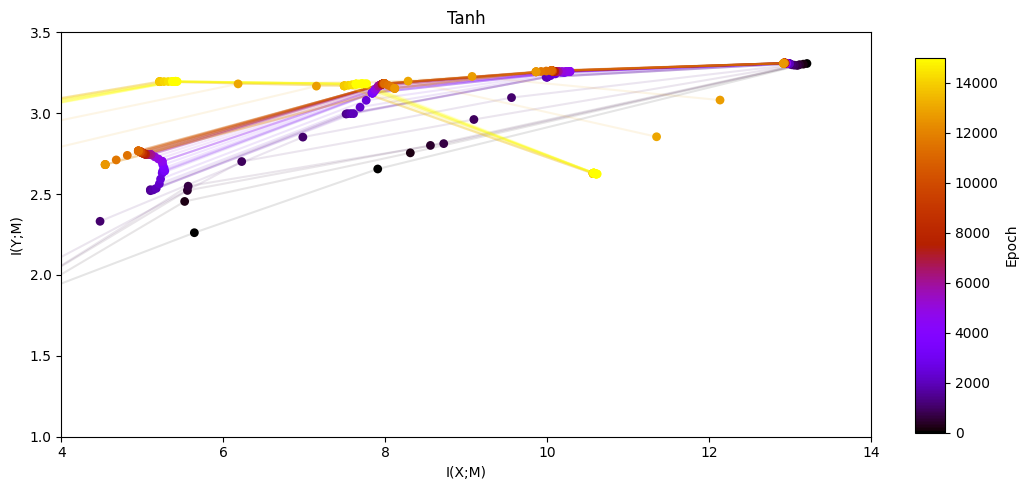

In [50]:
%matplotlib inline
import matplotlib
# matplotlib.use('TkAgg')
#matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
#sns.set_style('darkgrid')

plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 2)

COLORBAR_MAX_EPOCHS = 15000

plt.tight_layout()

fig = plt.figure(figsize=(10, 5))

sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

n_epoch = IXM_N.shape[0]

PLOT_LAYERS = [0]
for epoch in range(0, n_epoch):
    c = sm.to_rgba(220 * (epoch))
    xmvals = IXM_N[epoch]
    ymvals = IYM_N[epoch]
    
    plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
    plt.scatter(xmvals, ymvals, s=40, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

plt.ylim([1, 3.5])
plt.xlim([4, 14])
plt.xlabel('I(X;M)')
plt.ylabel('I(Y;M)')
plt.title('Tanh')

# colorbar
cbaxes = fig.add_axes([0.92, 0.125, 0.03, 0.75])
plt.colorbar(sm, label='Epoch', cax=cbaxes)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show(block=True)